In [20]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

from scipy.stats import ttest_ind, kstest

In [2]:
import json
import re

from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Loading data

In [4]:
DATASETS = ['svhn', 'cifar10', 'eurosat']
DATASET_LABELS = {
    'svhn': 'SVHN',
    'cifar10': 'CIFAR-10',
    'eurosat': 'EuroSAT'
}

DS_ORDER = ['SVHN', 'CIFAR-10', 'EuroSAT']
HR_ORDER = ['Contrastive + Structure (Baseline)', 'Behavior', 'Contrastive + Behavior', 'Structure + Behavior', 'Contrastive + Structure + Behavior']

HYPERREP_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune')

EXPERIMENT_PATH = Path.cwd() / 'results' 

In [5]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Model zoo',
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    hr_path = HYPERREP_PATH / f"{ds}_train_hyperrep"
    for path in os.listdir(hr_path):
        if not re.match('AE_trainable', path):
            continue
        path = hr_path / path

        with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
            config = json.load(ifh_config)
            result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})

        for edx in range(len(result)):
            df_hr.loc[len(df_hr)] = (
                DATASET_LABELS[ds],
                result.loc[edx]['trial_id'],
                config['optim::lr'],
                config['ae:lat_dim'],
                config['training::loss_distillation'],
                config['training::queryset_distillation'],
                config['training::queryset_dump'],
                config['training::n_queries_distillation'],
                config['training::gamma'],
                config['training::beta'],
                result.loc[edx]['training_iteration'],
                result.loc[edx]['loss/loss_train'],
                result.loc[edx]['loss/loss_contrast_train'],
                result.loc[edx]['loss/loss_recon_train'],
                result.loc[edx]['loss/loss_structure_train'],
                result.loc[edx]['loss/loss_behaviour_train'],
                result.loc[edx]['loss/loss_test'],
                result.loc[edx]['loss/loss_contrast_test'],
                result.loc[edx]['loss/loss_recon_test'],
                result.loc[edx]['loss/loss_structure_test'],
                result.loc[edx]['loss/loss_behaviour_test'],
                result.loc[edx]['dstk/test_acc_test'],
                result.loc[edx]['dstk/ggap_test']
            )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model zoo,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,1.344194,0.930796,1.390127,1.059503,1.045855,1.060222,0.791913,1.090034,0.559680,0.283559
1,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.275532,0.770928,0.220488,0.257198,0.887651,0.224016,0.591360,0.183200,0.554503,0.276677
2,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.266038,0.677502,0.220320,0.247892,0.708432,0.223653,0.544859,0.187963,0.550643,0.276275
3,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.264123,0.664841,0.219599,0.239949,0.652948,0.218212,0.527920,0.183800,0.551713,0.279411
4,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.261248,0.628665,0.220424,0.242219,0.741064,0.215964,0.495595,0.184894,0.538348,0.282729


In [6]:
idx_dict = {
    '00011': 'Contrastive + Structure (Baseline)',
    '00000': 'Behavior',
    '00006': 'Contrastive + Behavior',
    '00002': 'Structure + Behavior',
    '00008': 'Contrastive + Structure + Behavior'
}

df_hr['Hyper-representation'] = df_hr['Trial ID'].str.slice(start=-5).map(idx_dict)

### Loading $L^2_{weights}$

In [7]:
l2_weights = list()

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    df_l2_weights_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'df_zoo_l2weights.csv'
    df_l2_weights = pd.read_csv(df_l2_weights_path, index_col=0)
    
    df_l2_weights['Model zoo'] = DATASET_LABELS[ds]
    
    l2_weights.append(df_l2_weights)
    
l2_weights = pd.concat(l2_weights)
l2_weights.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Hyper-representation model,L2 (structure),MSE (structure),Model zoo
0,Contrastive + Structure (Baseline),36.630211,0.049923,SVHN
1,Contrastive + Structure (Baseline),32.174301,0.038516,SVHN
2,Contrastive + Structure (Baseline),29.809624,0.033062,SVHN
3,Contrastive + Structure (Baseline),28.346432,0.029896,SVHN
4,Contrastive + Structure (Baseline),25.570820,0.024328,SVHN


### Loading $L^2_{preds}$

In [8]:
l2_preds = list()

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    df_l2_preds_path = EXPERIMENT_PATH / f'hr_analysis_{ds}' / 'df_zoo_l2preds.csv'
    df_l2_preds = pd.read_csv(df_l2_preds_path, index_col=0)
    
    df_l2_preds['Model zoo'] = DATASET_LABELS[ds]
    
    l2_preds.append(df_l2_preds)
    
l2_preds = pd.concat(l2_preds)
l2_preds.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Hyper-representation model,L2 (behavior),MSE (behavior),Agreement,Model zoo
0,Contrastive + Structure (Baseline),1.006281,0.121435,0.217386,SVHN
1,Behavior,0.671536,0.049624,0.217386,SVHN
2,Contrastive + Behavior,0.671696,0.049618,0.217386,SVHN
3,Structure + Behavior,0.235445,0.010870,0.780040,SVHN
4,Contrastive + Structure + Behavior,0.241480,0.011683,0.781000,SVHN


## Analysing data

### Analysing structural distance ($L_2$)

In [9]:
df_dist_struct = l2_weights.groupby(['Hyper-representation model', 'Model zoo'])['L2 (structure)'].agg(['mean', 'std']).reset_index()
df_dist_struct['print'] = df_dist_struct['mean'].map(lambda x: f"{x:.1f}") + df_dist_struct['std'].map(lambda x: f" (±{x:.0f})")
df_dist_struct = df_dist_struct.pivot(index='Hyper-representation model', columns='Model zoo', values='print')
df_dist_struct = df_dist_struct.loc[HR_ORDER, DS_ORDER]
print(df_dist_struct.to_latex())
df_dist_struct

\begin{tabular}{llll}
\toprule
Model zoo &        SVHN &    CIFAR-10 &     EuroSAT \\
Hyper-representation model         &             &             &             \\
\midrule
Contrastive + Structure (Baseline) &  30.7 (±10) &  31.3 (±13) &  41.4 (±22) \\
Behavior                           &   57.8 (±6) &   59.5 (±9) &  67.5 (±17) \\
Contrastive + Behavior             &   55.7 (±7) &   60.7 (±9) &  67.4 (±17) \\
Structure + Behavior               &  26.9 (±10) &  29.6 (±13) &  45.5 (±21) \\
Contrastive + Structure + Behavior &  27.1 (±10) &  30.0 (±13) &  43.6 (±21) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3495/2934977399.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_dist_struct.to_latex())


Model zoo,SVHN,CIFAR-10,EuroSAT
Hyper-representation model,,,
Contrastive + Structure (Baseline),30.7 (±10),31.3 (±13),41.4 (±22)
Behavior,57.8 (±6),59.5 (±9),67.5 (±17)
Contrastive + Behavior,55.7 (±7),60.7 (±9),67.4 (±17)
Structure + Behavior,26.9 (±10),29.6 (±13),45.5 (±21)
Contrastive + Structure + Behavior,27.1 (±10),30.0 (±13),43.6 (±21)


In [13]:
for ds in DATASETS:
    ds_label = DATASET_LABELS[ds]
    struct = l2_weights[(l2_weights['Hyper-representation model'] == 'Contrastive + Structure (Baseline)') & (l2_weights['Model zoo'] == ds_label)]['L2 (structure)'].values
    strbeh = l2_weights[(l2_weights['Hyper-representation model'] == 'Contrastive + Structure + Behavior') & (l2_weights['Model zoo'] == ds_label)]['L2 (structure)'].values
    
    print(f"{ds_label}: P(μ1 = μ2) = {ttest_ind(struct, strbeh)[1]:.5f}")

SVHN: P(μ1 = μ2) = 0.00000
CIFAR-10: P(μ1 = μ2) = 0.05616
EuroSAT: P(μ1 = μ2) = 0.05003


In [22]:
for ds in DATASETS:
    ds_label = DATASET_LABELS[ds]
    struct = l2_weights[(l2_weights['Hyper-representation model'] == 'Contrastive + Structure (Baseline)') & (l2_weights['Model zoo'] == ds_label)]['L2 (structure)'].values
    strbeh = l2_weights[(l2_weights['Hyper-representation model'] == 'Contrastive + Structure + Behavior') & (l2_weights['Model zoo'] == ds_label)]['L2 (structure)'].values
    
    print(f"{ds_label}: P(KS) = {kstest(struct, strbeh)[1]:.5f}")

SVHN: P(KS) = 0.00000
CIFAR-10: P(KS) = 0.00000
EuroSAT: P(KS) = 0.00000


### Analysing behavioral distance (agreement)

In [14]:
df_dist_struct = l2_preds.groupby(['Hyper-representation model', 'Model zoo'])['Agreement'].agg(['mean', 'std']).reset_index()
df_dist_struct['print'] = df_dist_struct['mean'].map(lambda x: f"{x:.1%}") + df_dist_struct['std'].map(lambda x: f" (±{x:.0%})")
df_dist_struct = df_dist_struct.pivot(index='Hyper-representation model', columns='Model zoo', values='print')
df_dist_struct = df_dist_struct.loc[HR_ORDER, DS_ORDER]
print(df_dist_struct.to_latex())
df_dist_struct

\begin{tabular}{llll}
\toprule
Model zoo &          SVHN &      CIFAR-10 &       EuroSAT \\
Hyper-representation model         &               &               &               \\
\midrule
Contrastive + Structure (Baseline) &  50.0\% (±20\%) &  31.9\% (±16\%) &  35.9\% (±24\%) \\
Behavior                           &  26.6\% (±22\%) &   10.3\% (±8\%) &  19.2\% (±25\%) \\
Contrastive + Behavior             &  26.6\% (±22\%) &  11.8\% (±14\%) &  18.5\% (±25\%) \\
Structure + Behavior               &  86.1\% (±11\%) &  59.4\% (±20\%) &  66.5\% (±25\%) \\
Contrastive + Structure + Behavior &   87.0\% (±9\%) &  59.6\% (±19\%) &  65.8\% (±25\%) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3495/1650146689.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_dist_struct.to_latex())


Model zoo,SVHN,CIFAR-10,EuroSAT
Hyper-representation model,,,
Contrastive + Structure (Baseline),50.0% (±20%),31.9% (±16%),35.9% (±24%)
Behavior,26.6% (±22%),10.3% (±8%),19.2% (±25%)
Contrastive + Behavior,26.6% (±22%),11.8% (±14%),18.5% (±25%)
Structure + Behavior,86.1% (±11%),59.4% (±20%),66.5% (±25%)
Contrastive + Structure + Behavior,87.0% (±9%),59.6% (±19%),65.8% (±25%)


In [19]:
for ds in DATASETS:
    ds_label = DATASET_LABELS[ds]
    struct = l2_preds[(l2_preds['Hyper-representation model'] == 'Contrastive + Structure (Baseline)') & (l2_preds['Model zoo'] == ds_label)]['Agreement'].values
    strbeh = l2_preds[(l2_preds['Hyper-representation model'] == 'Contrastive + Structure + Behavior') & (l2_preds['Model zoo'] == ds_label)]['Agreement'].values
    
    print(f"{ds_label}: P(μ1 = μ2) = {ttest_ind(struct, strbeh)[1]:.9f}")

SVHN:	 P(μ1 = μ2) = 0.000000000
CIFAR-10:	 P(μ1 = μ2) = 0.000000000
EuroSAT:	 P(μ1 = μ2) = 0.000000000


In [23]:
for ds in DATASETS:
    ds_label = DATASET_LABELS[ds]
    struct = l2_preds[(l2_preds['Hyper-representation model'] == 'Contrastive + Structure (Baseline)') & (l2_preds['Model zoo'] == ds_label)]['Agreement'].values
    strbeh = l2_preds[(l2_preds['Hyper-representation model'] == 'Contrastive + Structure + Behavior') & (l2_preds['Model zoo'] == ds_label)]['Agreement'].values
    
    print(f"{ds_label}: P(KS) = {kstest(struct, strbeh)[1]:.9f}")

SVHN: P(KS) = 0.000000000
CIFAR-10: P(KS) = 0.000000000
EuroSAT: P(KS) = 0.000000000


### Plotting figures

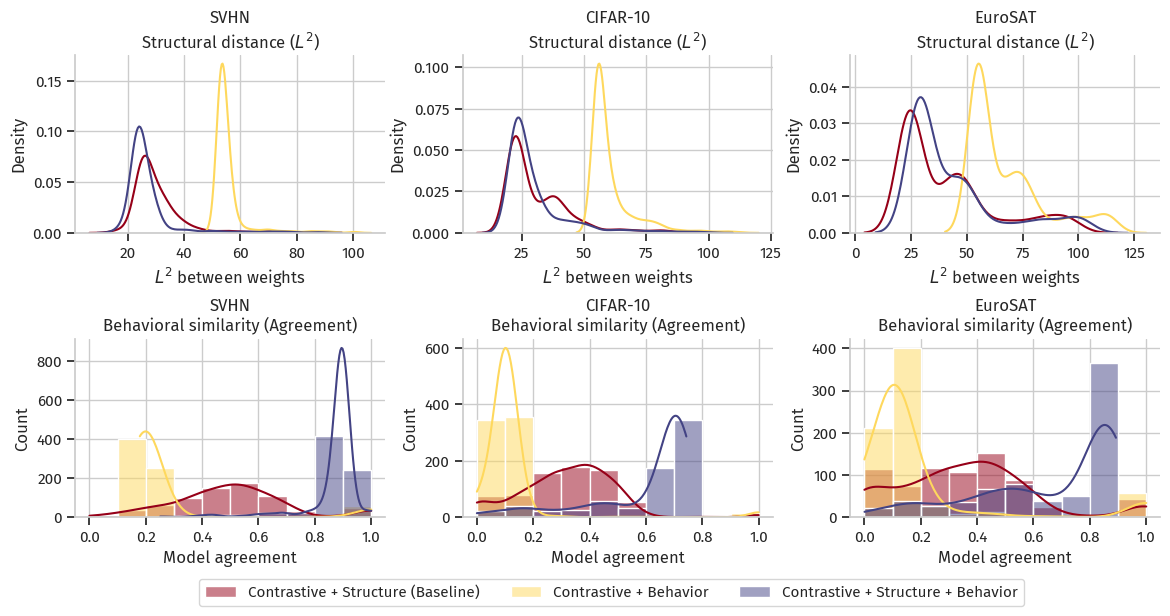

In [18]:
hr_to_plot = ['Contrastive + Structure (Baseline)', 'Contrastive + Behavior', 'Contrastive + Structure + Behavior']

_, axs = plt.subplots(2, 3, figsize=(14, 6))

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    df_s = l2_weights[l2_weights['Model zoo'] == ds_label]
    df_b = l2_preds[l2_preds['Model zoo'] == ds_label]

    for i, label in enumerate(hr_to_plot):
        sns.kdeplot(df_s[df_s['Hyper-representation model'] == label], x='L2 (structure)', color=COLOURS[i], label=label, ax=axs[0][d])
    axs[0][d].set(title=f"{ds_label}\nStructural distance ($L^2$)", xlabel="$L^2$ between weights")
    
    for i, label in enumerate(hr_to_plot):
        sns.histplot(df_b[df_b['Hyper-representation model'] == label], x='Agreement', binwidth=0.1, binrange=(0., 1.), kde=True, color=COLOURS[i], label=label, ax=axs[1][d])
    axs[1][d].set(title=f"{ds_label}\nBehavioral similarity (Agreement)", xlabel="Model agreement")
    
plt.legend(loc=(-2.1, -0.50), ncols=3)
plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.savefig('figures/reconstructive_dstk.png', dpi=300, bbox_inches='tight')
plt.show()